<h1>Dog Breed Classification</h1><br>
<br>

<a id='Intro'></a>
## <h1>Introduction</h1>

There are many different versions of dog breeds that are out there in the world. I will use image classification algorithms to provide the most accurate predictions of using deep learning to have it correctly predict dog breeds based on the images that it detects and generates. 

<br>
The setup consists of a labels.csv file which consists of breed names and the image ids. There are two folders, test and train, that contain images of dogs. There will be training done on the images in the train folder. The Kaggle competition ended in February 2018, and if there is an opportunity in the future to submit my results, that will come up when it is most appropriate. In the meantime, for this project, I will not be submitting anything for the dog breed image classification project. 
<br>
The dataset comes from Kaggle, as the Dog Breed Identfication problem was a competition that was posted on their website. The citation can be found here.
<br><br>
Will Cukierski. Dog Breed Identification. https://kaggle.com/competitions/dog-breed-identification, 2017. Kaggle.
<br>


Notes:<br>
This was executed on an Anaconda environment using the following packages and respective versions.
<br>
<ul>
<li>Python v3.10.13</li>
<li>Tensorflow v2.12.0</li>
<li>Keras v2.12.0</li>
<li>Numpy v1.23.5</li>
<li>Pandas v2.2.3</li>
<li>Matplotlib-base v3.10.0</li>
</ul>

In [44]:
# Import basic libraries
import pandas as pd
import numpy as np
import os

# Import TensorFlow / Keras libraries to be used
import tensorflow as tf # Use tf v2.12.0
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Get the TensorFlow Version - we are using v2.12.0
print(tf.__version__)

2.12.0


In [3]:
# Get the current working directory
os.getcwd()

'/Users/mjchin/Desktop/CUB_OMS_CS/Summer_2025/CSCA_5642_Intro_DL/FinalProject/dogbreedclassification'

In [4]:
# Go back one directory
os.chdir("..")

In [5]:
os.getcwd()

'/Users/mjchin/Desktop/CUB_OMS_CS/Summer_2025/CSCA_5642_Intro_DL/FinalProject'

<a id='EDA'></a>
## <h1>Exploratory Data Analysis</h1>

Take a look at some of the labels to get an understanding of the data that involves dog breeds. Open the CSV file and we will see the respective image IDs tied to a different dog breed.

In [6]:
# The path to the files should not be like this all the time; everything done offline
# Actual project is found on Kaggle, but elected to run on own environment which best fit needs
labels = pd.read_csv("dog-breed-identification/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Now, get some information on the overall strucutre of the labels database. This includes the shape, column names, type info, and descriptive statistics, among others.

In [7]:
labels.shape

(10222, 2)

In [8]:
labels.columns

Index(['id', 'breed'], dtype='object')

In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [10]:
labels.isnull()

,id,breed
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
10217,False,False
10218,False,False
10219,False,False
10220,False,False


In [11]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


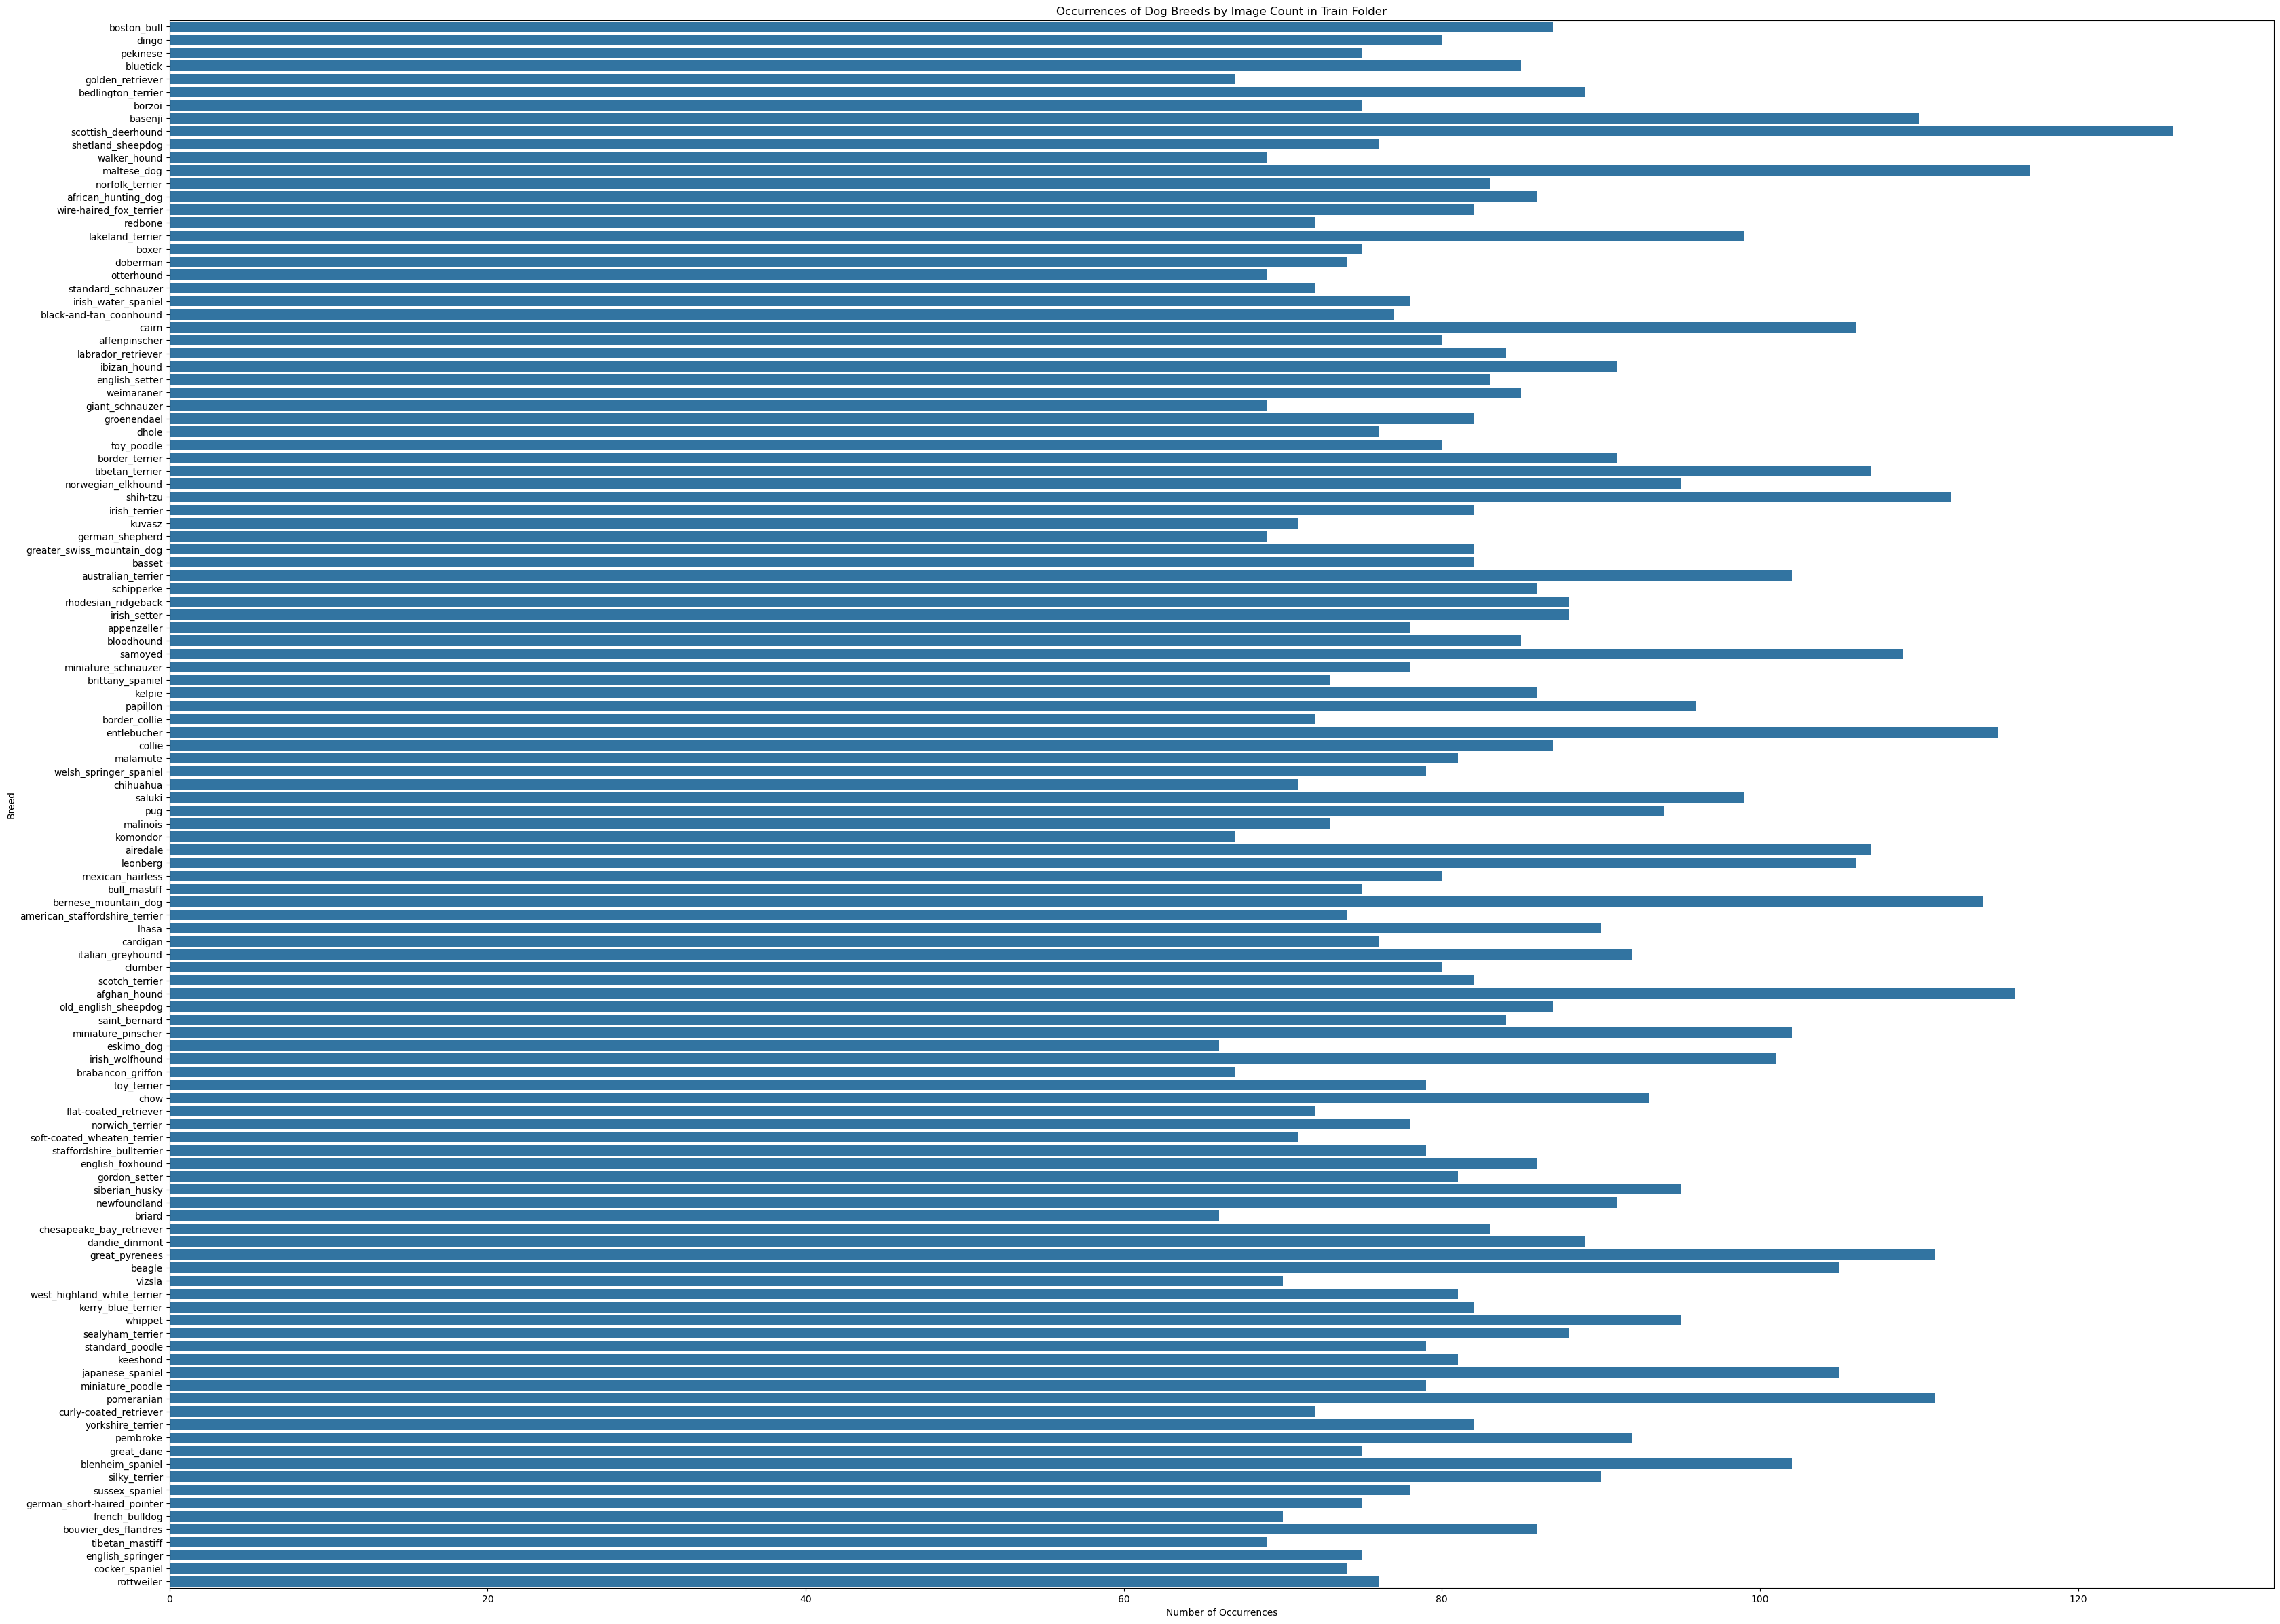

In [98]:
# Visualize dog breed counts
plt.figure(figsize=(40,30))
sns.countplot(y="breed",data=labels)
plt.xlabel("Number of Occurrences")
plt.ylabel("Breed")
plt.title("Occurrences of Dog Breeds by Image Count in Train Folder")
plt.show()

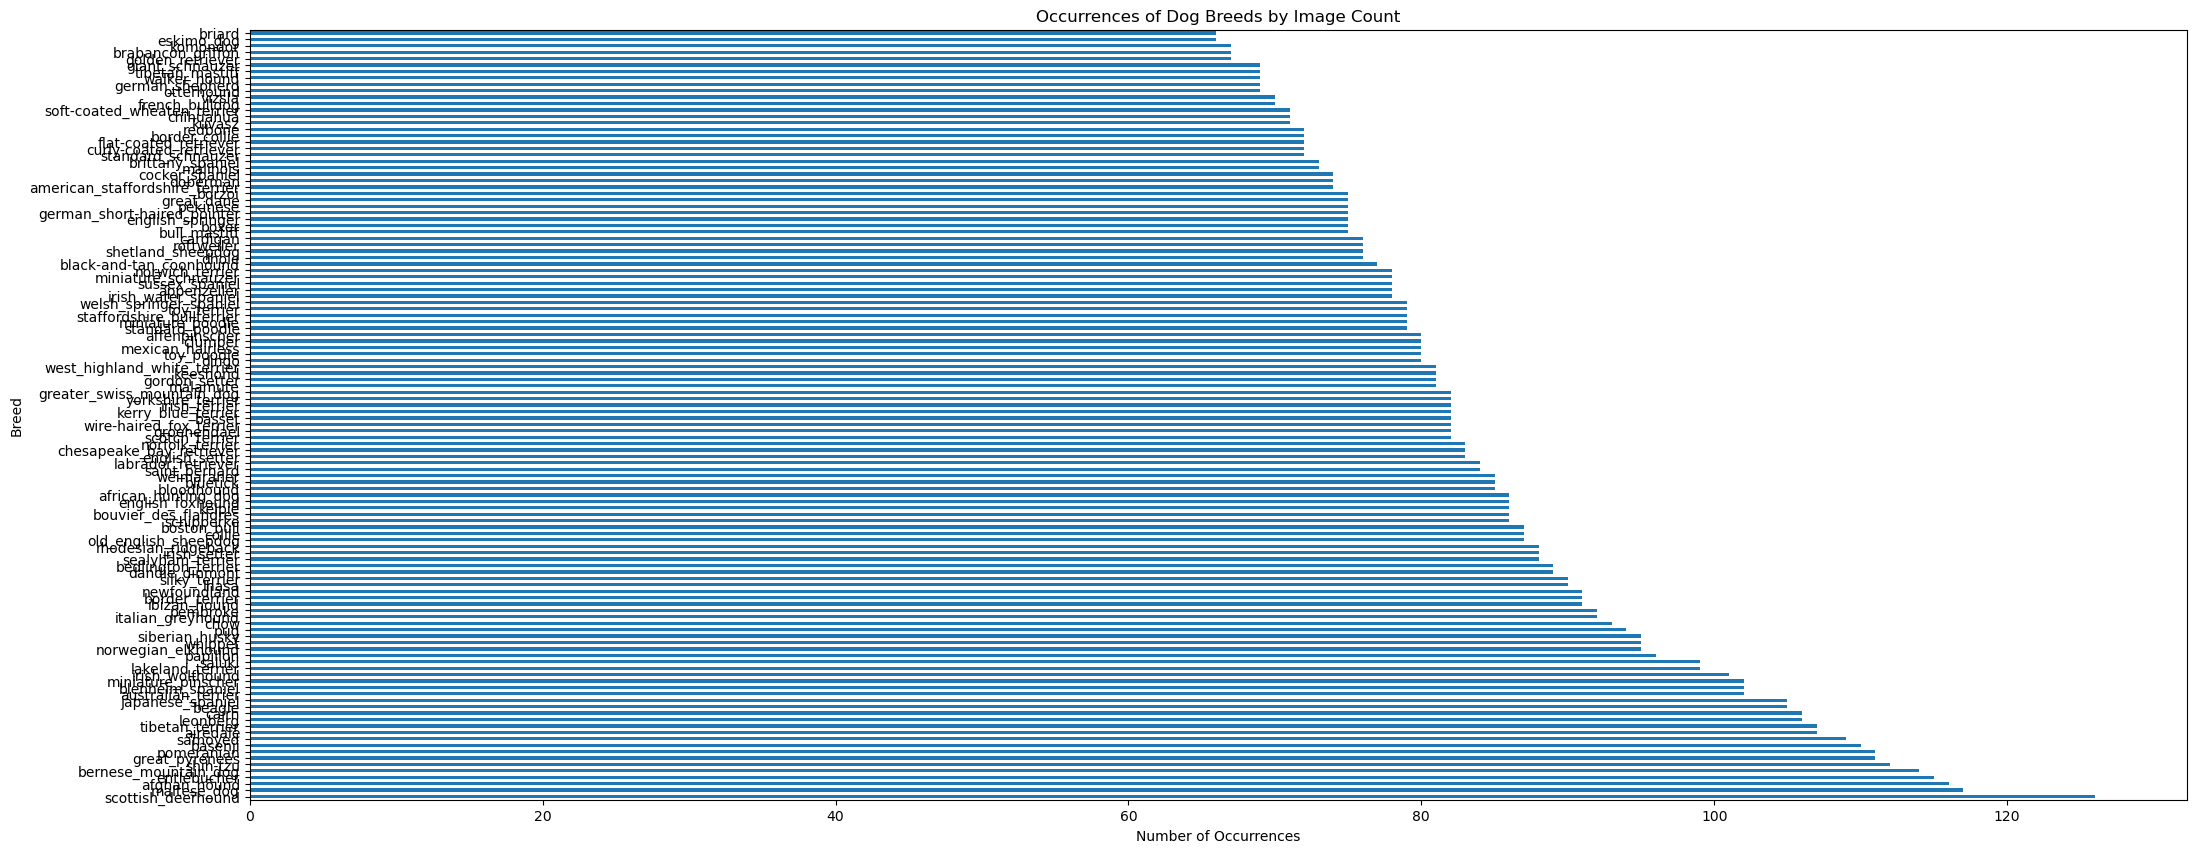

In [ ]:
# Show all dog breed images occurrences in order, ascending from least to most
labels['breed'].value_counts().plot.barh(figsize=(25,10))
plt.xlabel("Number of Occurrences")
plt.ylabel("Breed")
plt.title("Occurrences of Dog Breeds by Image Count")
plt.show()

Get a few samples of images from train directory - note that the file types for the images ends in '.jpg'. 
First, use the Image package from the IPython library to get single images, then follow it up with multiple batches of images by dog breed.

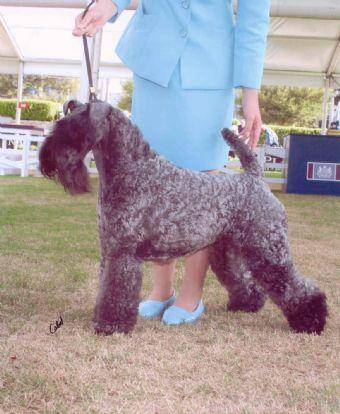

In [ ]:
from IPython.display import Image
Image("dog-breed-identification/train/0a1f8334a9f583cac009dc033c681e47.jpg")

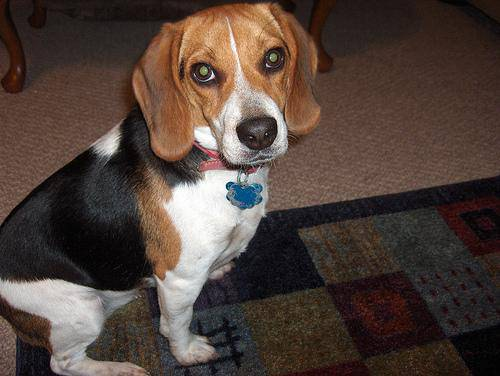

In [15]:
Image("dog-breed-identification/train/0b9d58d8d2626f80bbc5cc3ccf7e8bad.jpg")

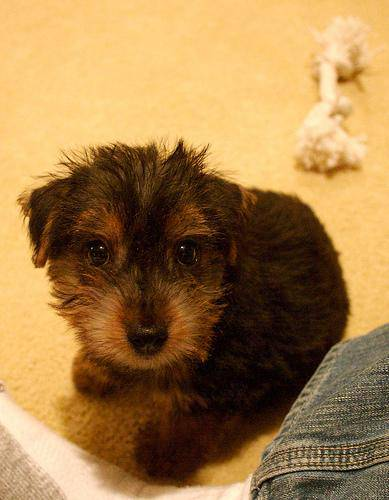

In [16]:
Image("dog-breed-identification/train/fc33f90570fc8502e6c3f83a6bf3b982.jpg")

Before doing batches of images by dog breed, take a look at what our goal is: to submit a file with appropriate labels to image IDs. 
<br>
Since this came from a Kaggle competition, take a look at the sample_submission.csv file that came with all the data that was downloaded locally. The purpose of this image classification is to predict the probability that a dog image consists of at least one of several different dog breeds. The higher the probability percentage, the more likely that that image is that dog breed.  
<br>
For the purpose of this project, we will not be submitting a CSV file, but will make one as if it is in the competition. I am using older versions of Python, TensorFlow, Keras, etc., due to past and present familiarity with these versions.

In [17]:
# Get first five rows of the sample submit file 
sample = pd.read_csv("dog-breed-identification/sample_submission.csv")
sample.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


(227, 380, 3)
(333, 500, 3)
(376, 500, 3)
(389, 479, 3)
(375, 500, 3)
(188, 250, 3)
(375, 500, 3)
(392, 500, 3)
(333, 500, 3)
(349, 500, 3)


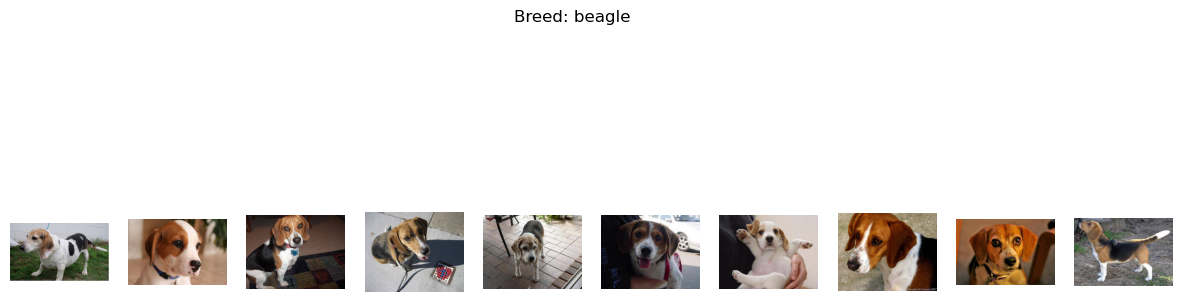

In [ ]:
import cv2

# Also shows the image of any one shape - or the number of pixels on any one image
base_path='dog-breed-identification/train'
def show_samples(df, breed, n=10):
    samples = df[df['breed'] == breed].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for img_id, ax in zip(samples['id'], axes):
        # img = get_image(img_id)
        path = os.path.join(base_path, f"{img_id}.jpg")
        img = cv2.imread(path)
        print(img.shape)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.suptitle(f"Breed: {breed}")
    plt.show()

# Show samples of beagles
show_samples(labels, breed='beagle')

In [53]:
# Get how many Beagle images there are in train dataset - should be 105
labels[labels['breed'] == 'beagle'].shape

(105, 2)

(290, 402, 3)
(500, 333, 3)
(333, 500, 3)
(333, 500, 3)
(348, 394, 3)
(500, 333, 3)
(500, 375, 3)
(338, 500, 3)
(500, 333, 3)
(1704, 2272, 3)


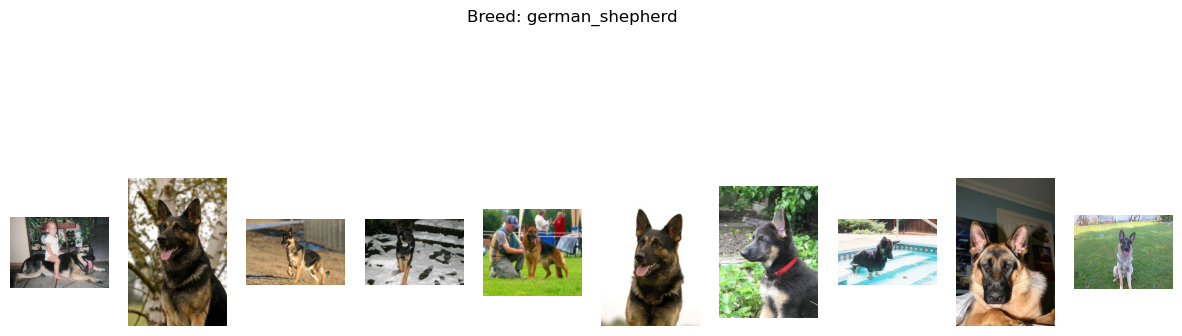

In [54]:
# Show samples of German Shepherds
show_samples(labels, breed='german_shepherd')

In [55]:
# Get how many German Shepherd images there are in train dataset - should be 69
labels[labels['breed'] == 'german_shepherd'].shape

(69, 2)

In [ ]:
# Get value counts of all dog breeds occurrences from labels dataset
labels['breed'].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64


In [87]:
len(labels['breed'])

10222

In [97]:
labels['breed'].value_counts().median()

82.0

In [88]:
# Find how many unique breeds there are in the labels dataset
len(labels['breed'].unique())

120

In [89]:
# Get top 25 breeds with most occurring labels found
top25breeds= labels['breed'].value_counts().head(25)

# Type Series, convert to DataFrame
print(type(top25breeds))

top25breeds = top25breeds.reset_index()
print(type(top25breeds))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [90]:
# Get new top 25 breeds dataframe
print(top25breeds.shape)
print(top25breeds.columns)
print(top25breeds)

(25, 2)
Index(['breed', 'count'], dtype='object')
                   breed  count
0     scottish_deerhound    126
1            maltese_dog    117
2           afghan_hound    116
3            entlebucher    115
4   bernese_mountain_dog    114
5               shih-tzu    112
6         great_pyrenees    111
7             pomeranian    111
8                basenji    110
9                samoyed    109
10              airedale    107
11       tibetan_terrier    107
12              leonberg    106
13                 cairn    106
14                beagle    105
15      japanese_spaniel    105
16    australian_terrier    102
17      blenheim_spaniel    102
18    miniature_pinscher    102
19       irish_wolfhound    101
20      lakeland_terrier     99
21                saluki     99
22              papillon     96
23    norwegian_elkhound     95
24               whippet     95


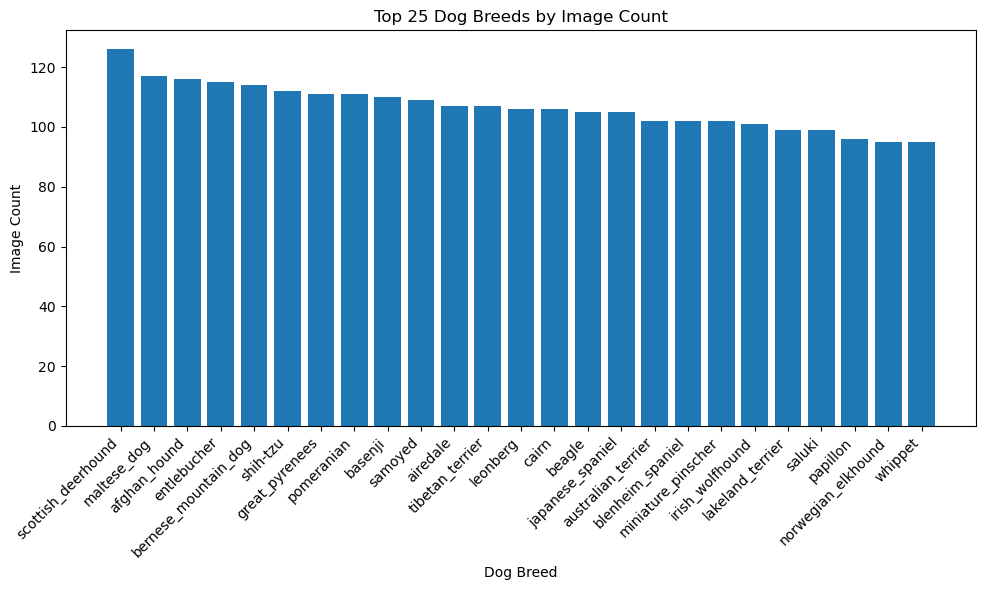

In [92]:
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
plt.bar(top25breeds['breed'], top25breeds['count'])
plt.xlabel("Dog Breed")
plt.ylabel("Image Count")
plt.title("Top 25 Dog Breeds by Image Count")
plt.xticks(range(len(top25breeds)), rotation=45, ha='right')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# Get count of images in train directory 
len(os.listdir('dog-breed-identification/train'))

10222

In [ ]:
# Get count of images in test directory
len(os.listdir('dog-breed-identification/test'))

10357

<a id='Data Prep'></a>
## <h1>Data Preparation</h1>

After some visualizations, it is time to prepare our data. 
